# Preparating Data

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import  Pool

%matplotlib inline

In [2]:
train_data = pd.read_parquet('C:/Users/DavidG/Documents/american_express_data/fillna_data_0.parquet')
for i in range(1, 4):
    train_data = pd.concat([train_data, pd.read_parquet('C:/Users/DavidG/Documents/american_express_data/fillna_data_{}.parquet'.format(i))])
train_data.reset_index(drop = True, inplace = True)

In [3]:
# Section only for select columns too empty
#columns = []
#nan_values = []
#for column in train_data_sample.columns:
#    try:
#        nan_value = np.sum(np.isnan(train_data_sample[column]))
#        if nan_value != 0:
#            columns.append(column)
#            nan_values.append(nan_value)
#    except:
#        ;
#columns_with_nan = pd.DataFrame(data = nan_values, index = columns)
#columns_to_drop = columns_with_nan[columns_with_nan[0] > len(train_data_sample)*frac_nan_values].index.values
#train_data_sample.drop(labels = columns_to_drop, axis = 1, inplace = True)
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)
    print("g value is {} and d value is {}".format(g, d))

    return 0.5 * (g + d)

In [4]:
train_data.replace([np.inf, -np.inf], 0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['customer_ID', 'target'], axis = 1), train_data['target'], random_state=0)
del train_data
sc = StandardScaler() 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 
#pca = PCA(n_components = 60).fit(x_train_2)
#x_train_2 = pca.transform(x_train_2)
#x_test_2 = pca.transform(x_test_2)
#mds = MDS(n_components = 20)
#x_train_2 = mds.fit_transform(x_train_2)
#x_test_2 = mds.transform(x_test_2)

#tsne = TSNE(random_state = 0)

#x_train_2 = tsne.fit_transform(x_train_2)
#x_test_2 = tsne.transform(x_test_2)

In [5]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42, 
                           eval_metric = 'auc', max_depth = 3, learning_rate = 0.2, gamma = 0.1)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [6]:
y_predict = xgb_clf.predict(X_test)
y_predict_proba = xgb_clf.predict_proba(X_test)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_predict)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_predict)))
print('F1: {:.2f}'.format(f1_score(y_test, y_predict)))
print(amex_metric(pd.DataFrame(y_test), pd.DataFrame(y_predict_proba, index = y_test.index, columns = ['prediction'])))

Accuracy: 0.89
Precision: 0.80
Recall: 0.79
F1: 0.79
g value is 0.9071184422510328 and d value is 0.6105746663984443
0.7588465543247385


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

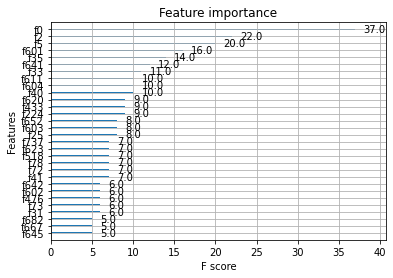

In [8]:
#plt.barh(xgb_clf.feature_names, xgb_clf.feature_importances_)
from xgboost import plot_importance
plot_importance(xgb_clf, max_num_features =30)

In [10]:
logreg = LogisticRegression(max_iter = 1000, C = 0.05, class_weight = [1, 95]).fit(X_train, y_train)

In [11]:
y_predict = logreg.predict(X_test)
y_predict_proba = logreg.predict_proba(X_test)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_predict)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_predict)))
print('F1: {:.2f}'.format(f1_score(y_test, y_predict)))
print(amex_metric(pd.DataFrame(y_test), pd.DataFrame(y_predict_proba, index = y_test.index, columns = ['prediction'])))

Accuracy: 0.89
Precision: 0.81
Recall: 0.77
F1: 0.79
g value is 0.9049570183653801 and d value is 0.6058472473680682
0.7554021328667242


In [26]:
test_data = pd.read_parquet('C:/Users/DavidG/Documents/american_express_data/test_fillna_data_0.parquet')
test_data.replace([np.inf, -np.inf], 0, inplace=True)
index = test_data.index
test_data = sc.transform(test_data)
y_predict_proba = xgb_clf.predict_proba(test_data)[:,1]
prediction = pd.DataFrame(data = y_predict_proba, index = index, columns = ['prediction'])

In [28]:
for i in range(1, 10):
    test_data = pd.read_parquet('C:/Users/DavidG/Documents/american_express_data/test_fillna_data_{}.parquet'.format(i))
    test_data.replace([np.inf, -np.inf], 0, inplace=True)
    index = test_data.index
    test_data = sc.transform(test_data)
    y_predict_proba = xgb_clf.predict_proba(test_data)[:,1]
    prediction = pd.concat([prediction, pd.DataFrame(data = y_predict_proba, index = index, columns = ['prediction'])])

In [30]:
prediction.to_csv('C:/Users/DavidG/Documents/american_express_data/prediction.csv')